# Testing package `Whirl2d`

In [1]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a basic domain with no body

In [2]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 0


#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [3]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 0
Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [4]:
Re = 200
physparams = NavierStokes.set_freestream([1.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,0.5*Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)

(Whirl2d.NavierStokes.PhysParams([1.0, 0.0], 200.0), 0.125)

### Compute the grid and body operators
This fills in the LGF and integrating factor tables and defines the operators needed for calling the IF-RK

In [5]:
@time ops = NavierStokes.set_operators!(dom,params);
A⁻¹,r₁ = ops

  1.552326 seconds (1.56 M allocations: 362.023 MiB, 3.04% gc time)


(Whirl2d.NavierStokes.A⁻¹, Whirl2d.NavierStokes.r₁)

### Create an initial solution structure

In [8]:
s = NavierStokes.Soln(dom)

Whirl2d.Soln(0.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

### Set initial condition

In [9]:
x = [dom.grid.xmin[1]+Δx*(i-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]
y = [dom.grid.xmin[2]+Δx*(j-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]
σ = 0.2
wexact(t) = exp.(-((x-t).^2+y.^2)/(σ^2+4t/Re))/(1+4t/(Re*σ^2));
s.u[dom.grid.cellint[1],dom.grid.cellint[2]] = dom.grid.Δx*wexact(0.0);
s.ψ = -Grids.L⁻¹(dom.grid,s.u);

### Advance the solution

In [10]:
@time for i = 1:150
    s = TimeMarching.ifrk!(s,tparams,A⁻¹,r₁)
end
s

 16.304185 seconds (147.91 M allocations: 12.302 GiB, 11.89% gc time)


Whirl2d.Soln(1.500000000000001, [-1.83801e-19 -2.06803e-19 … 8.27737e-19 4.9327e-19; -2.68675e-19 -1.8545e-19 … 9.57826e-19 5.73191e-19; … ; -8.61549e-18 -1.68553e-17 … 2.15851e-18 4.64946e-19; -5.50799e-18 -9.67272e-18 … 2.96596e-19 1.00219e-19], [-5.8855 -5.8756 … -5.8756 -5.8855; -5.8756 -5.8655 … -5.8655 -5.8756; … ; -6.67826 -6.67625 … -6.67625 -6.67826; -6.68425 -6.68226 … -6.68226 -6.68425])

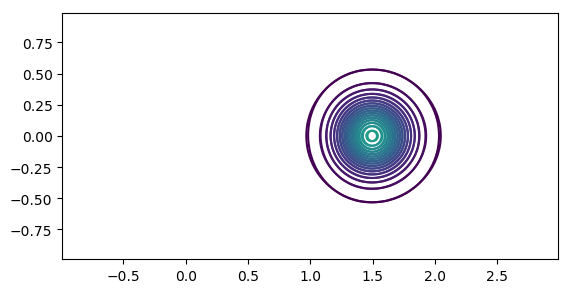

(-0.99, 2.99, -0.99, 0.99)

In [11]:
contour(x,y,s.u[dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(0.01,1,30))
contour(x,y,wexact(s.t),linspace(0.01,1,30))
axis("scaled")

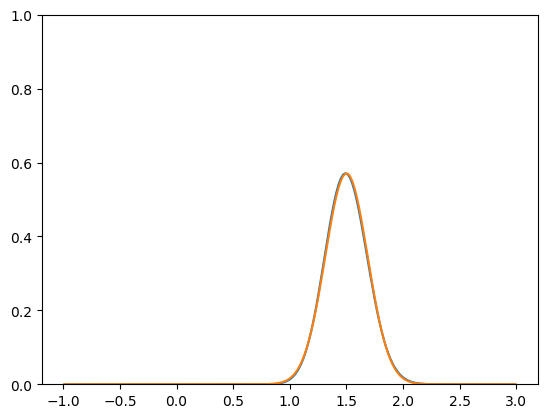

(0.0, 1.0)

In [13]:
plot(x[:,51],s.u[2:end-1,51]/Δx)
plot(x[:,51],wexact(s.t)[:,51])
ylim(0.0,1.0)

### Create a body

In [14]:
Npts = 100
rad = 0.5
xcent = [0.0,0.0]
ang = 0.0
b = Bodies.Circle(Npts,rad,xcent,ang)

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]


### Create a domain with this body in it

In [15]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [16]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [17]:
Re = 200
physparams = NavierStokes.set_freestream([1.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,0.5*Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)

(Whirl2d.NavierStokes.PhysParams([1.0, 0.0], 200.0), 0.125)

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [18]:
@time ops = NavierStokes.set_operators_body!(dom,params);
A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂ = ops

 10.753948 seconds (75.94 M allocations: 5.057 GiB, 5.92% gc time)


(Whirl2d.NavierStokes.A⁻¹, Whirl2d.NavierStokes.B₁ᵀ, Whirl2d.NavierStokes.B₂!, Whirl2d.NavierStokes.S⁻¹, Whirl2d.NavierStokes.S₀⁻¹, Whirl2d.NavierStokes.r₁, Whirl2d.NavierStokes.r₂)

### Create an initial solution structure

In [19]:
s = NavierStokes.BodySoln(dom)

Solution: t = 0.0


### Advance the solution

In [20]:
@time for i = 1:100
    s = TimeMarching.ifherk!(s,tparams,A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂)
end
s

 17.372801 seconds (159.81 M allocations: 11.947 GiB, 12.79% gc time)


Solution: t = 1.0000000000000007


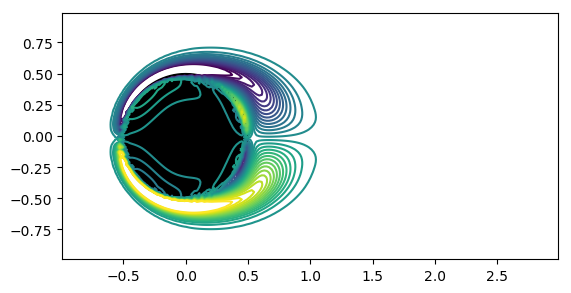

(-0.99, 2.99, -0.99, 0.99)

In [21]:
x = [dom.grid.xmin[1]+Δx*(i-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]
y = [dom.grid.xmin[2]+Δx*(j-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]

contour(x,y,s.u[dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")

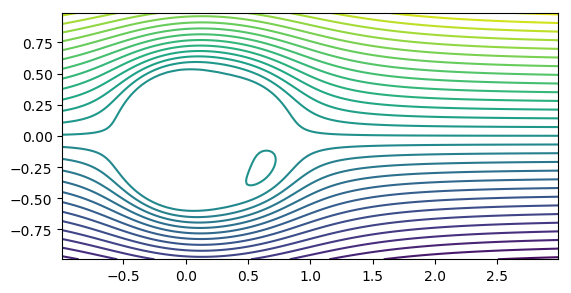

(-0.99, 2.99, -0.99, 0.99)

In [22]:
s.ψ = -Grids.L⁻¹(dom.grid,s.u)
contour(x,y,s.ψ[dom.grid.cellint[1],dom.grid.cellint[2]]*Δx+y,linspace(-1,1,31))
axis("scaled")

Plot the C<sup>T</sup> E<sub>y</sub><sup>T</sup> operator

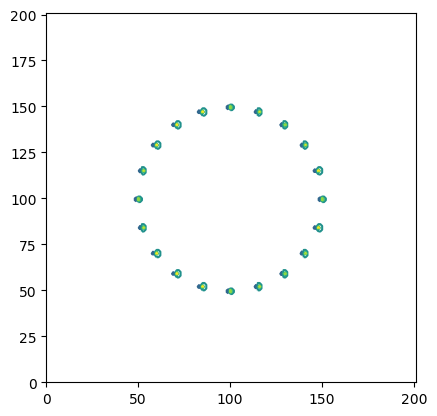

(0.0, 201.0, 0.0, 201.0)

In [190]:
contour(reshape(dom.ECᵀ[1]*ones(dom.nbodypts),size(dom.grid.cell)))
axis("scaled")

In [15]:
# Create a "grid unit vector": a bunch of cell data with zeros everywhere except at one point.
# This is useful for visualizing the LGF and the integrating factor
wunit = zeros(dom.grid.cell);
wunit[40,40] = 1.0;

In [192]:
# This is the discrete convolution of the integrating factor with the grid unit vector
# The result is just the integrating factor field, but shifted to the center specified
# in the grid unit vector.
@time s = Grids.Q(dom.grid,wunit);

  0.037541 seconds (264.80 k allocations: 14.863 MiB, 13.88% gc time)


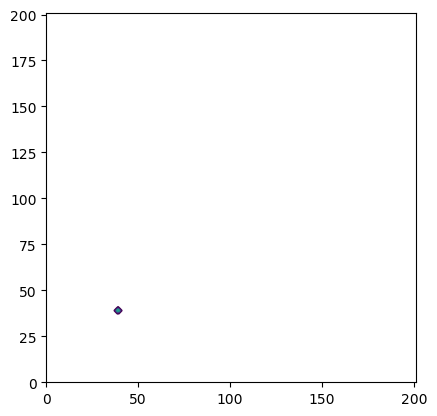

(0.0, 201.0, 0.0, 201.0)

In [193]:
# plot this
contour(s,linspace(0.01,1,31))
axis("scaled")

In [194]:
# This is the discrete convolution of the LGF with the grid unit vector
@time s = Grids.L⁻¹(dom.grid,wunit);

  0.022773 seconds (245.24 k allocations: 13.999 MiB)


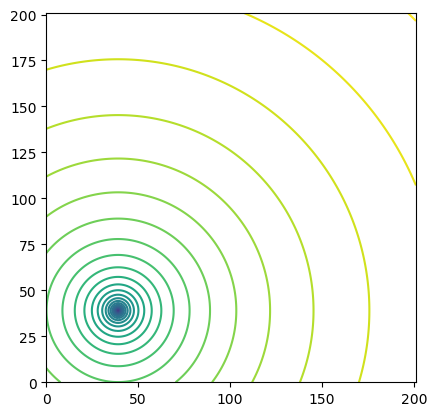

(0.0, 201.0, 0.0, 201.0)

In [195]:
# plot this
contour(s,31)
axis("scaled")